# End to End Object Detection with Transformers in ART

Demo for applying the DEtection TRansformer (DETR) estimator in ART for object detection and attacking the Detection Transformer using the Robust DPatch method.

### Define imports, constants and helper functions

In [5]:
from art.estimators.object_detection.pytorch_detection_transformer import PyTorchDetectionTransformer
from art.attacks.evasion.adversarial_patch.adversarial_patch_pytorch import AdversarialPatchPyTorch
from torchvision.transforms import transforms
import PIL.Image
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import requests
import pandas as pd

COCO_CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

def extract_predictions(predictions_, conf_thresh):
    predictions_class = [COCO_CLASSES[i] for i in list(predictions_["labels"])]
    if len(predictions_class) < 1:
        return [], [], []
        
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_["boxes"])]
    predictions_score = list(predictions_["scores"])

    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t
    else:
        return [], [], []
        
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores

def plot_image_with_boxes(img, boxes, pred_cls, title):
    text_size = 2
    text_th = 2
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)
    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img)

def filter_boxes(predictions, conf_thresh):
    dictionary = {}

    boxes_list = []
    scores_list = []
    labels_list = []

    for i in range(len(predictions[0]["boxes"])):
        score = predictions[0]["scores"][i]
        if score >= conf_thresh:
            boxes_list.append(predictions[0]["boxes"][i])
            scores_list.append(predictions[0]["scores"][[i]])
            labels_list.append(predictions[0]["labels"][[i]])

    dictionary["boxes"] = np.vstack(boxes_list)
    dictionary["scores"] = np.hstack(scores_list)
    dictionary["labels"] = np.hstack(labels_list)

    y = [dictionary]

    return y

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
NUMBER_CHANNELS = 3
INPUT_SHAPE = (NUMBER_CHANNELS, 800, 800)

transform = transforms.Compose([
        transforms.Resize([INPUT_SHAPE[1], INPUT_SHAPE[2]], interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ])


### Load COCO images and resize

In [2]:
urls = ['http://images.cocodataset.org/val2017/000000039769.jpg',
'http://images.cocodataset.org/val2017/000000397133.jpg',
'http://images.cocodataset.org/val2017/000000037777.jpg',
'http://images.cocodataset.org/val2017/000000454661.jpg',
'http://images.cocodataset.org/val2017/000000094852.jpg']
coco_images = []
for url in urls:
    im = PIL.Image.open(requests.get(url, stream=True).raw)
    im = transform(im).numpy()
    coco_images.append(im)
coco_images = np.array(coco_images)

### Create the detector

In [3]:
detector = PyTorchDetectionTransformer(channels_first=True, preprocessing=(MEAN, STD), input_shape=INPUT_SHAPE, clip_values=(0,1))

Using cache found in /Users/kieranfraser/.cache/torch/hub/facebookresearch_detr_main
/Users/kieranfraser/git/personal/art/env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/kieranfraser/git/personal/art/env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Test detector on COCO images

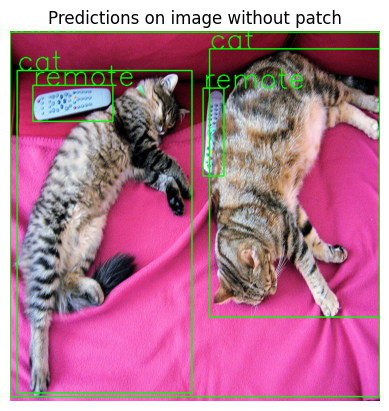

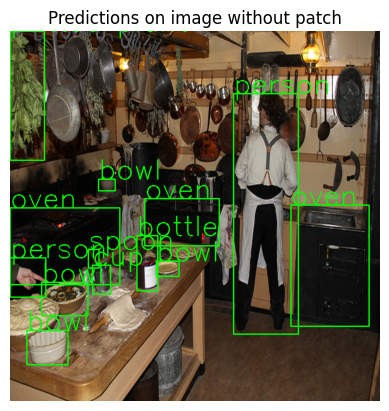

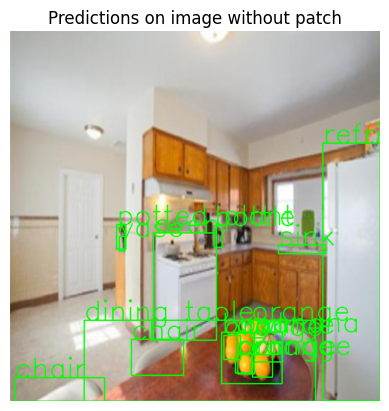

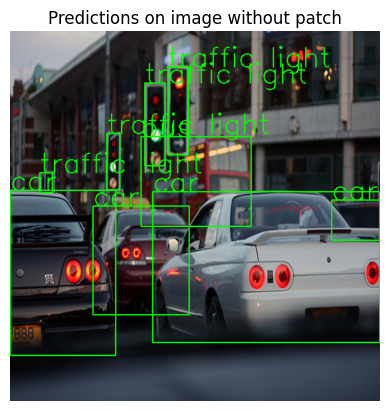

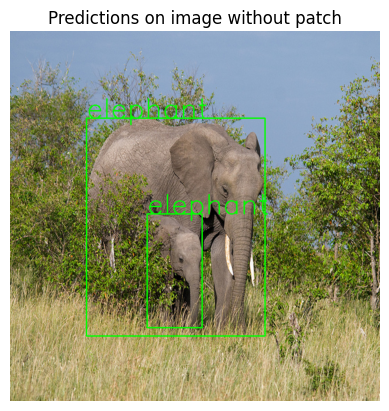

In [8]:
results = detector.predict(coco_images)
for i in range(len(results)):
    preds = extract_predictions(results[i], 0.8)
    im = (torch.from_numpy(coco_images)[i].numpy().transpose(1,2,0)*255).astype(np.uint8)
    plot_image_with_boxes(img=im.copy(), boxes=preds[1], pred_cls=preds[0], title="Predictions on image without patch")

### PGD Attack
Targeted PGD attack using the last image above of elephants to create adversarial examples that force DETR to see elephants in other images.

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


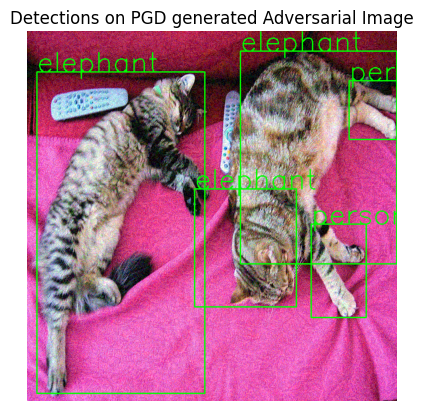

In [5]:
from art.attacks.evasion import ProjectedGradientDescent

attack = ProjectedGradientDescent(detector, targeted=True, max_iter=100, eps=0.1)

dets = detector.predict(coco_images)
filtered_dets = [filter_boxes([t], 0.8)[0] for t in dets]

x = coco_images[[0]]
target = filtered_dets[-1:]

adv = attack.generate(x, y=target)

adv_dets = detector.predict(adv)
preds = extract_predictions(adv_dets[0], 0.8)
im = adv[0].transpose(1,2,0)
plot_image_with_boxes(img=im.copy(), boxes=preds[1], pred_cls=preds[0], title=f"Detections on PGD generated Adversarial Image")


### Adversarial Patch Attack
1. Targeted patch attack using elephant image from COCO as target to generate patch that forces DETR to detect elephants in images when patch applied.
2. Untargeted patch attack causing DETR to detect random objects not relevant to the image
3. Untargeted patch attack plot of loss components over epochs

##### Targeted attack

Adversarial Patch PyTorch:   0%|          | 0/200 [00:00<?, ?it/s]

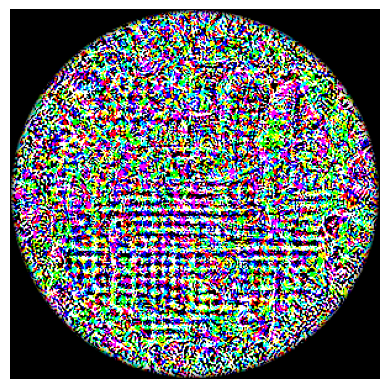

In [42]:
dets = detector.predict(coco_images)
filtered_dets = [filter_boxes([t], 0.8)[0] for t in dets]

x = coco_images[:-1]
targets = [filtered_dets[-1] for i in range(len(x))]

rotation_max=0.0
scale_min=0.5
scale_max=1
distortion_scale_max=0.0
learning_rate=1.99
max_iter=200
batch_size=16
patch_shape=(3, 300, 300)
patch_location=(100,100)
patch_type="circle"
optimizer="adam"

ap = AdversarialPatchPyTorch(estimator=detector, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max, distortion_scale_max=distortion_scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size, patch_location=patch_location,
                      patch_shape=patch_shape, patch_type=patch_type, verbose=True, targeted=True)

patch, patch_mask = ap.generate(x=x[[0]], y=targets[:1])

plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


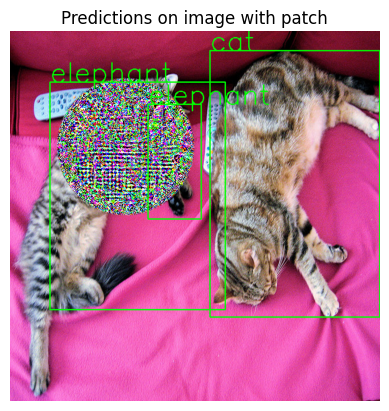

In [43]:
patched_images = ap.apply_patch(coco_images[:1], scale=0.4)
dets = detector.predict(patched_images)
for i in range(len(dets)):
    preds_orig = extract_predictions(dets[i], 0.8)
    plot_image_with_boxes(img=patched_images[i].transpose(1,2,0).copy(), boxes=preds_orig[1], pred_cls=preds_orig[0],
                           title="Predictions on image with patch")

##### Untargeted attack

/Users/kieranfraser/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


Adversarial Patch PyTorch:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/kieranfraser/git/personal/art/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:417: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/Users/kieranfraser/git/personal/art/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:675: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


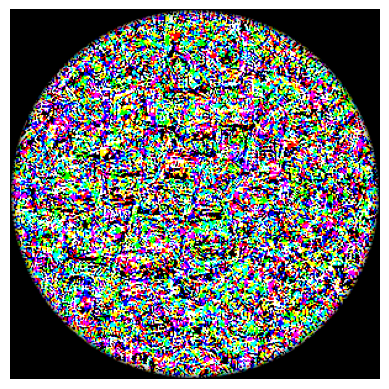

In [47]:
dets = detector.predict(coco_images)
filtered_dets = [filter_boxes([t], 0.8)[0] for t in dets]

x = coco_images[:-1]
targets = [filtered_dets[-1] for i in range(len(x))]

rotation_max=0.0
scale_min=0.5
scale_max=1
distortion_scale_max=0.0
learning_rate=1.99
max_iter=50
batch_size=16
patch_shape=(3, 300, 300)
patch_location=(100,100)
patch_type="circle"
optimizer="adam"

ap = AdversarialPatchPyTorch(estimator=detector, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max, distortion_scale_max=distortion_scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size, patch_location=patch_location,
                      patch_shape=patch_shape, patch_type=patch_type, verbose=True, targeted=False)

patch, patch_mask = ap.generate(x=x[[0]], y=filtered_dets[:1])

plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Patched prediction classes for image 1: ['car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'couch', 'cat', 'car', 'car', 'car', 'cat']


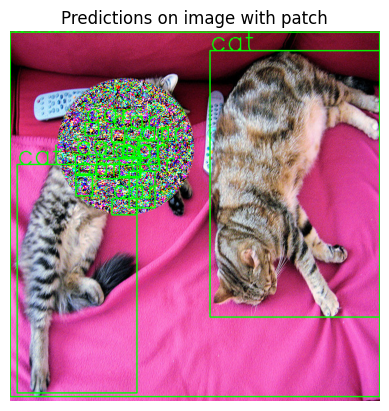

In [55]:
patched_images = ap.apply_patch(coco_images[[0]], scale=0.4)
dets = detector.predict(patched_images)
for i in range(len(dets)):
    preds_orig = extract_predictions(dets[i], 0.8)
    plot_image_with_boxes(img=patched_images[i].transpose(1,2,0).copy(), boxes=preds_orig[1], pred_cls=preds_orig[0],
                           title="Predictions on image with patch")
    print(f'Patched prediction classes for image {i+1}:', preds_orig[0])

##### Untargeted attack plotting the loss components over epochs

/Users/kieranfraser/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
  0%|          | 0/50 [00:00<?, ?it/s]/Users/kieranfraser/git/personal/art/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:417: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/Users/kieranfraser/git/personal/art/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:675: UserWarning: Argument 'interpolation' of t

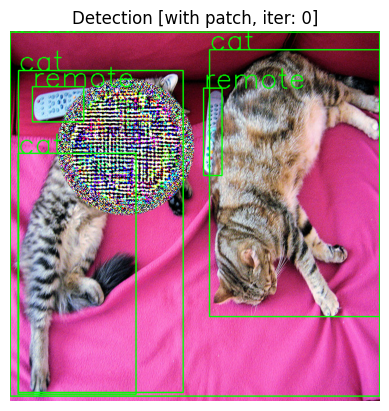

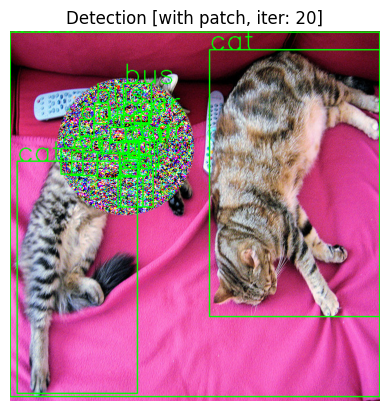

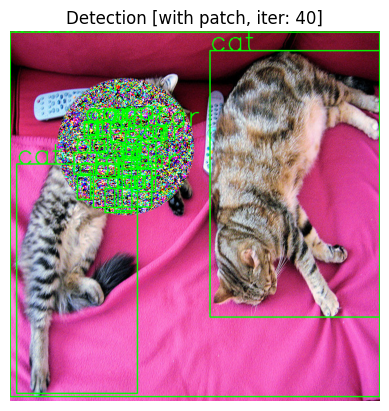

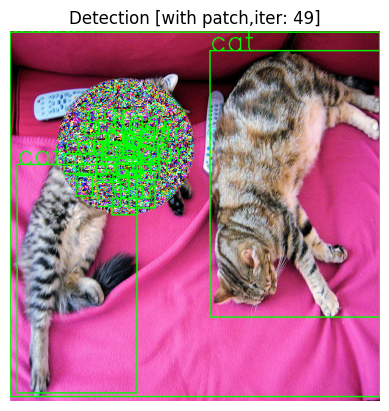

In [93]:
from tqdm import tqdm

dets = detector.predict(coco_images)
y = [filter_boxes([t], 0.8)[0] for t in dets]

x = coco_images[:-1]
target = [y[-1] for i in range(len(coco_images[:-1]))]

rotation_max=0.0
scale_min=0.5
scale_max=1
distortion_scale_max=0.0
learning_rate=1.99
max_iter=1
batch_size=16
patch_shape=(3, 300, 300)
patch_location=(100,100)
patch_type="circle"
optimizer="adam"

attack = AdversarialPatchPyTorch(estimator=detector, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max, distortion_scale_max=distortion_scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size, patch_location=patch_location,
                      patch_shape=patch_shape, patch_type=patch_type, verbose=False, targeted=False)

loss_history = []
for i in tqdm(range(50)):
    patch = attack.generate(x[[0]], y[:1])
    patched_images = attack.apply_patch(x[[0]], scale=0.4)

    loss_components = detector.compute_losses(patched_images, y[:1])
    losses = {}
    for loss in loss_components.keys():
        if 'loss' in loss:
            losses[loss] = loss_components[loss].item()
    loss_history.append(losses)

    if i%20==0:
        _y = detector.predict(patched_images)
        preds = extract_predictions(_y[0], 0.5)
        im = (patched_images[0].transpose(1,2,0))
        plot_image_with_boxes(img=im.copy(), boxes=preds[1], pred_cls=preds[0], title=f"Detection [with patch, iter: {i}]")

_y = detector.predict(patched_images)
preds = extract_predictions(_y[0], 0.5)
im = (patched_images[0].transpose(1,2,0))
plot_image_with_boxes(img=im.copy(), boxes=preds[1], pred_cls=preds[0], title=f"Detection [with patch,iter: {i}]")

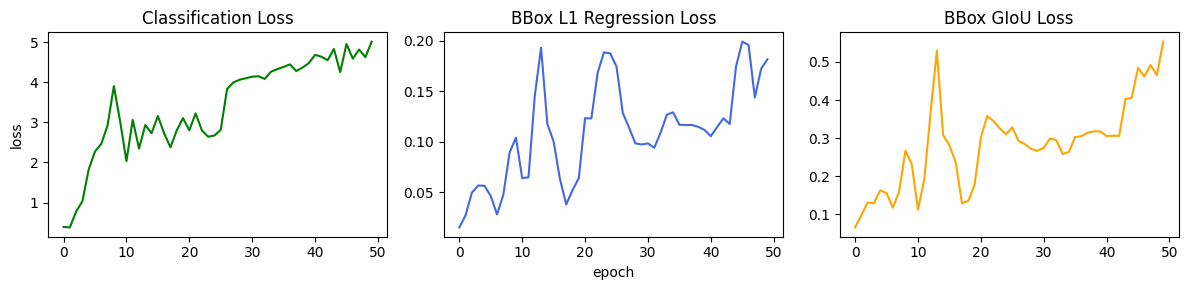

In [94]:
losses = pd.DataFrame(loss_history)
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,3))
losses.loss_ce.plot(ylabel='loss', ax = axes[0], subplots=True, color='g')
losses.loss_bbox.plot(xlabel='epoch', ax = axes[1],subplots=True, color='royalblue')
losses.loss_giou.plot( ax = axes[2],subplots=True, color='orange')


axes[0].set_title('Classification Loss')
axes[1].set_title('BBox L1 Regression Loss')
axes[2].set_title('BBox GIoU Loss')
fig.tight_layout()